# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [2]:
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jax.tree_util import tree_map
import jax.random as jr


# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree






# To make nice plots : 
from simulate.plot_trajectory import plot_training


# The simulated environment :
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import TrainingEnvironment,run_loop,generate_synthetic_data

# The methods to predict actions, compute the log-likelihoods and fit the models :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from functools import partial


# The artificial agents : 
from agents_full_actions import choice_kernel_agent,rw_agent
from agents_full_actions import random_agent
from simulate.hmm_weights import basic_latent_model # For the active inference model


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
NTRIALS = 10
T = 11

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 50
TRUE_FEEDBACK_STD = 0.15
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)


# Depending on the dimensions of the problem :
models_constants = {
    "angle" : {
        "N_actions" : 9
    },
    "distance" : {
        "N_actions" : 4
    },
    "position" : {
        "N_actions" : 9
    }
}

Example of behaviour simulated by a given model in the environment :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
10


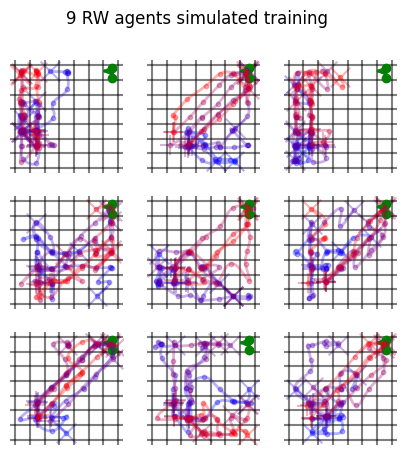

In [4]:
NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 RW agents simulated training")

rw_agent_hyperparameters ={
    "angle":{
        "alpha":0.1,
        "beta" :40.0
    },
    "position":{
        "alpha":0.3,
        "beta" :4.0
    },
    "distance":{
        "alpha":0.1,
        "beta" :40.0
    }
}

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    params_final,training_hist = run_loop(ENVIRONMENT,rw_agent(rw_agent_hyperparameters,models_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)

print(len(training_hist["actions"]))

Generate some synthetic data for the model we're interested in :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
GT LL : 
{'angle': Array(-140.70682, dtype=float32), 'distance': Array(-138.65524, dtype=float32), 'position': Array(-220.00705, dtype=float32)}


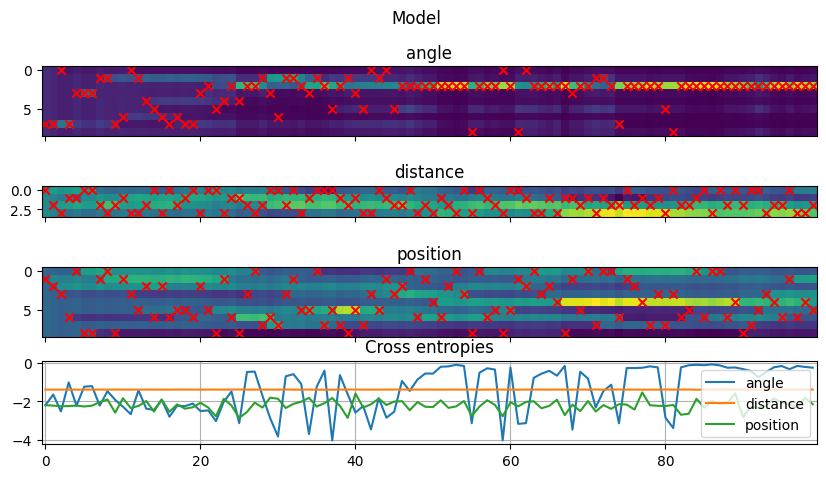

In [5]:

GT_rw_agent_hyperparameters = {
    "angle":{
        "alpha":0.1,
        "beta" :40.0
    },
    "position":{
        "alpha":0.3,
        "beta" :4.0
    },
    "distance":{
        "alpha":0.1,
        "beta" :0.1
    }
}

SYNTHETIC_DATA = generate_synthetic_data(ENVIRONMENT,rw_agent(GT_rw_agent_hyperparameters,models_constants),
                                         n_trials=10,seed = 0,verbose = True)
(formatted_stimuli,bool_stimuli,rewards,true_actions,tmtsp) = SYNTHETIC_DATA


# Optimal likelihood for the data (the best predictive power we should be able to achieve ):
lls,ces = compute_loglikelihood(SYNTHETIC_DATA,rw_agent(GT_rw_agent_hyperparameters,models_constants),"sum")
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,rw_agent(GT_rw_agent_hyperparameters,models_constants))
# print(predicted_actions)
model_states,other_data = state_history
qt_history,last_action_history = model_states


# plt.imshow(np.reshape(ck_history["position"],(-1,9)))
fig,axs = plt.subplots(len(true_actions)+1,1,figsize=(10,5),sharex=True)
fig.suptitle("Model")

for i,key in enumerate(predicted_actions.keys()):
    ax = axs[i]

    N_action_cat = true_actions[key].shape[-1]
    
    prediction_map = np.reshape(predicted_actions[key],(-1,N_action_cat))
    ax.set_title(key)    
    ax.imshow(prediction_map.T)
        
    N_timesteps  = prediction_map.shape[0]
    ax.scatter(np.arange(N_timesteps),np.argmax(true_actions[key],axis=-1),color="red",marker="x")

ax = axs[-1]
ax.set_title("Cross entropies")
for mod,series in ces.items():
    ax.plot(series.flatten(),label=mod)
ax.legend()
ax.grid()

print("GT LL : ")
print(lls)

[[[-2.1972246  -1.7240663  -2.4366317  ... -2.194499   -1.5549006
   -2.0023553 ]
  [-2.2333872  -2.5627694  -1.5401573  ... -2.18984    -2.2397072
   -2.1228993 ]
  [-2.4820716  -2.3777835  -2.848968   ... -0.64295185 -1.6758244
   -2.6423717 ]
  ...
  [-1.4221675  -2.33693    -1.5775945  ... -0.62088823 -0.49012437
   -0.6111356 ]
  [-2.082933   -2.5279584  -0.6111883  ... -0.44533557 -0.7260175
   -0.69180614]
  [-0.84529656 -0.9935986  -1.4309437  ... -0.47761115 -0.59590214
   -0.67926645]]

 [[-2.1972246  -1.7653025  -2.4158638  ... -2.2291548  -1.6407362
   -1.9292583 ]
  [-2.263256   -2.5606122  -1.5729178  ... -2.2029507  -2.1742136
   -2.071169  ]
  [-2.3539717  -2.409395   -2.8303359  ... -0.6548315  -1.7761555
   -2.6174285 ]
  ...
  [-0.44735128 -2.4568343  -1.7738113  ... -0.15955408 -0.11658949
   -0.13876699]
  [-3.6061146  -4.008622   -0.13530216 ... -0.06580358 -0.10963631
   -0.10332526]
  [-0.13140853 -0.16427696 -0.2823044  ... -0.07299923 -0.08956417
   -0.1021535

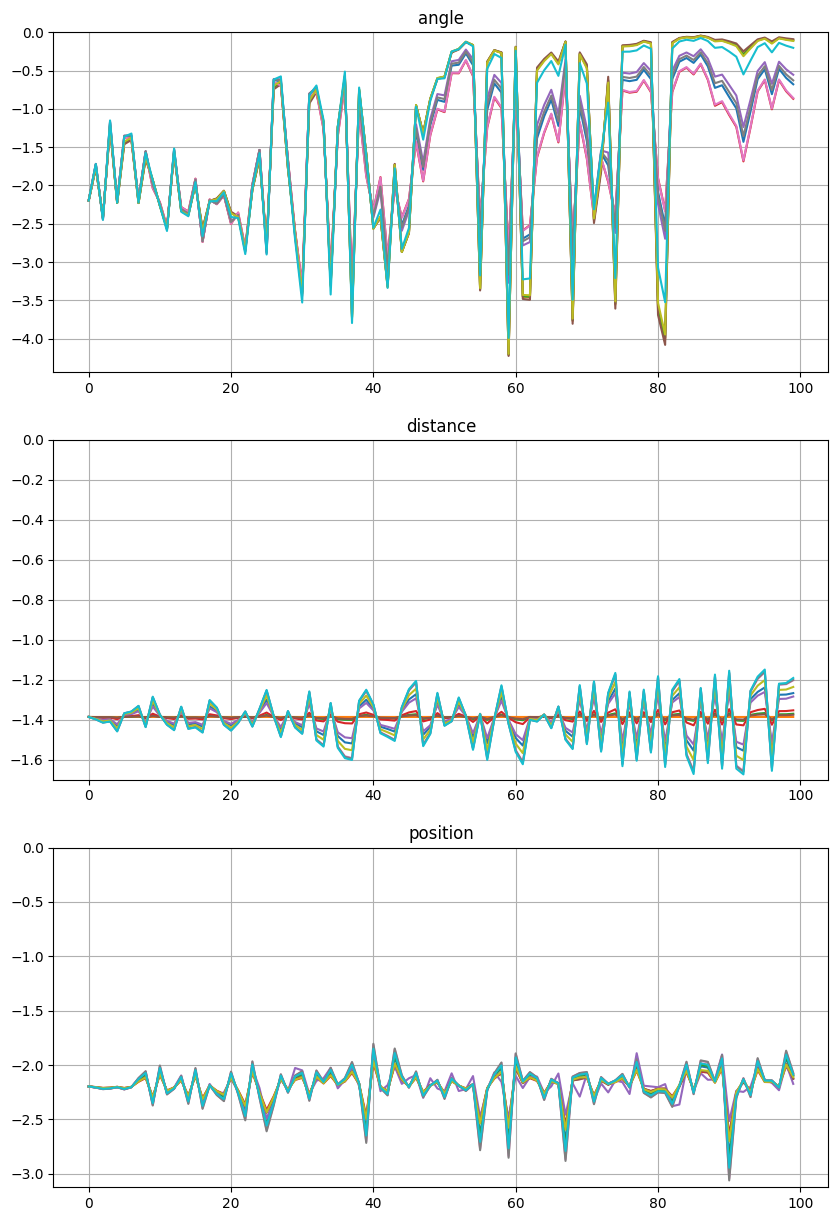

In [6]:


# Assuming uniform distributions for all parameters :
feature_range_tree ={
    "angle":{
        "alpha":jnp.array([-10,10]),
        "beta" :jnp.array([0,100]),
    },
    "position":{
        "alpha":jnp.array([-10,10]),
        "beta" :jnp.array([0,100]),
    },
    "distance":{
        "alpha":jnp.array([-10,10]),
        "beta" :jnp.array([0,100]),
    }
}
static_agent = partial(rw_agent,constants= models_constants)

all_fin_params,(gt_mle,all_losses,all_param_histories),encoding_function = fit_mle_agent(SYNTHETIC_DATA,
                            static_agent,feature_range_tree,jax.random.PRNGKey(0),
                            n_heads=100,num_steps=250)

final_lls,cross_entropies = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,static_agent(encoding_function(x)),"sum"))(all_fin_params)

print(cross_entropies["angle"])

fig,axs = plt.subplots(3,1,figsize=(10,15))
for i,key in enumerate(cross_entropies.keys()):
    axs[i].set_title(key)
    for head in range(10):
        axs[i].plot(cross_entropies[key][head].flatten())
    axs[i].set_ylim(ymax=0.0)
    axs[i].grid()
plt.show()